<a href="https://colab.research.google.com/github/phyllisUW/datascienceProject371/blob/main/INFO371_TEAM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Prediction Models to Predict Popular Music

---



In [ ]:
# If you can make a visualization whenever possible for slides that would be good.

In [ ]:
# Download necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Investigating the data (2023 dataset), which features should not be included when investigating the data and capturing variance?

While there are no features that stand out as needing to be omitted, we may not be as interested in streaming data for platforms other than Spotify (Apple Music, Deezer, and Shazam data is also included).

In [ ]:
# Added latin-1 thanks to StackOverflow tip with csv reading error:
# https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
df_data = pd.read_csv('/content/drive/MyDrive/spotify-2023.csv', encoding='latin-1')
# rename column because python had issues reading the parentheses
df_data.rename(columns = {"artist(s)_name": "artist_name"}, inplace = True)
# remove specific row with a misinput in the "streams" column
df_data.drop(df_data.loc[df_data.artist_name == "Edison Lighthouse"].index, inplace=True)

In [ ]:
# Download data, get familiarized with the data at a basic level.

In [ ]:
print(df_data.columns)
print(df_data.shape)
df_data.head(10)

Index(['track_name', 'artist_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')
(952, 24)


,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6
5,Sprinter,"Dave, Central Cee",2,2023,6,1,2186,91,183706234,67,...,141,C#,Major,92,66,58,19,0,8,24
6,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2,2023,3,16,3090,50,725980112,34,...,148,F,Minor,67,83,76,48,0,8,3
7,Columbia,Quevedo,1,2023,7,7,714,43,58149378,25,...,100,F,Major,67,26,71,37,0,11,4
8,fukumean,Gunna,1,2023,5,15,1096,83,95217315,60,...,130,C#,Minor,85,22,62,12,0,28,9
9,La Bebe - Remix,"Peso Pluma, Yng Lvcas",2,2023,3,17,2953,44,553634067,49,...,170,D,Minor,81,56,48,21,0,8,33


In [ ]:
# Use pairplot to visualize the different features in relation to the target (for slides).

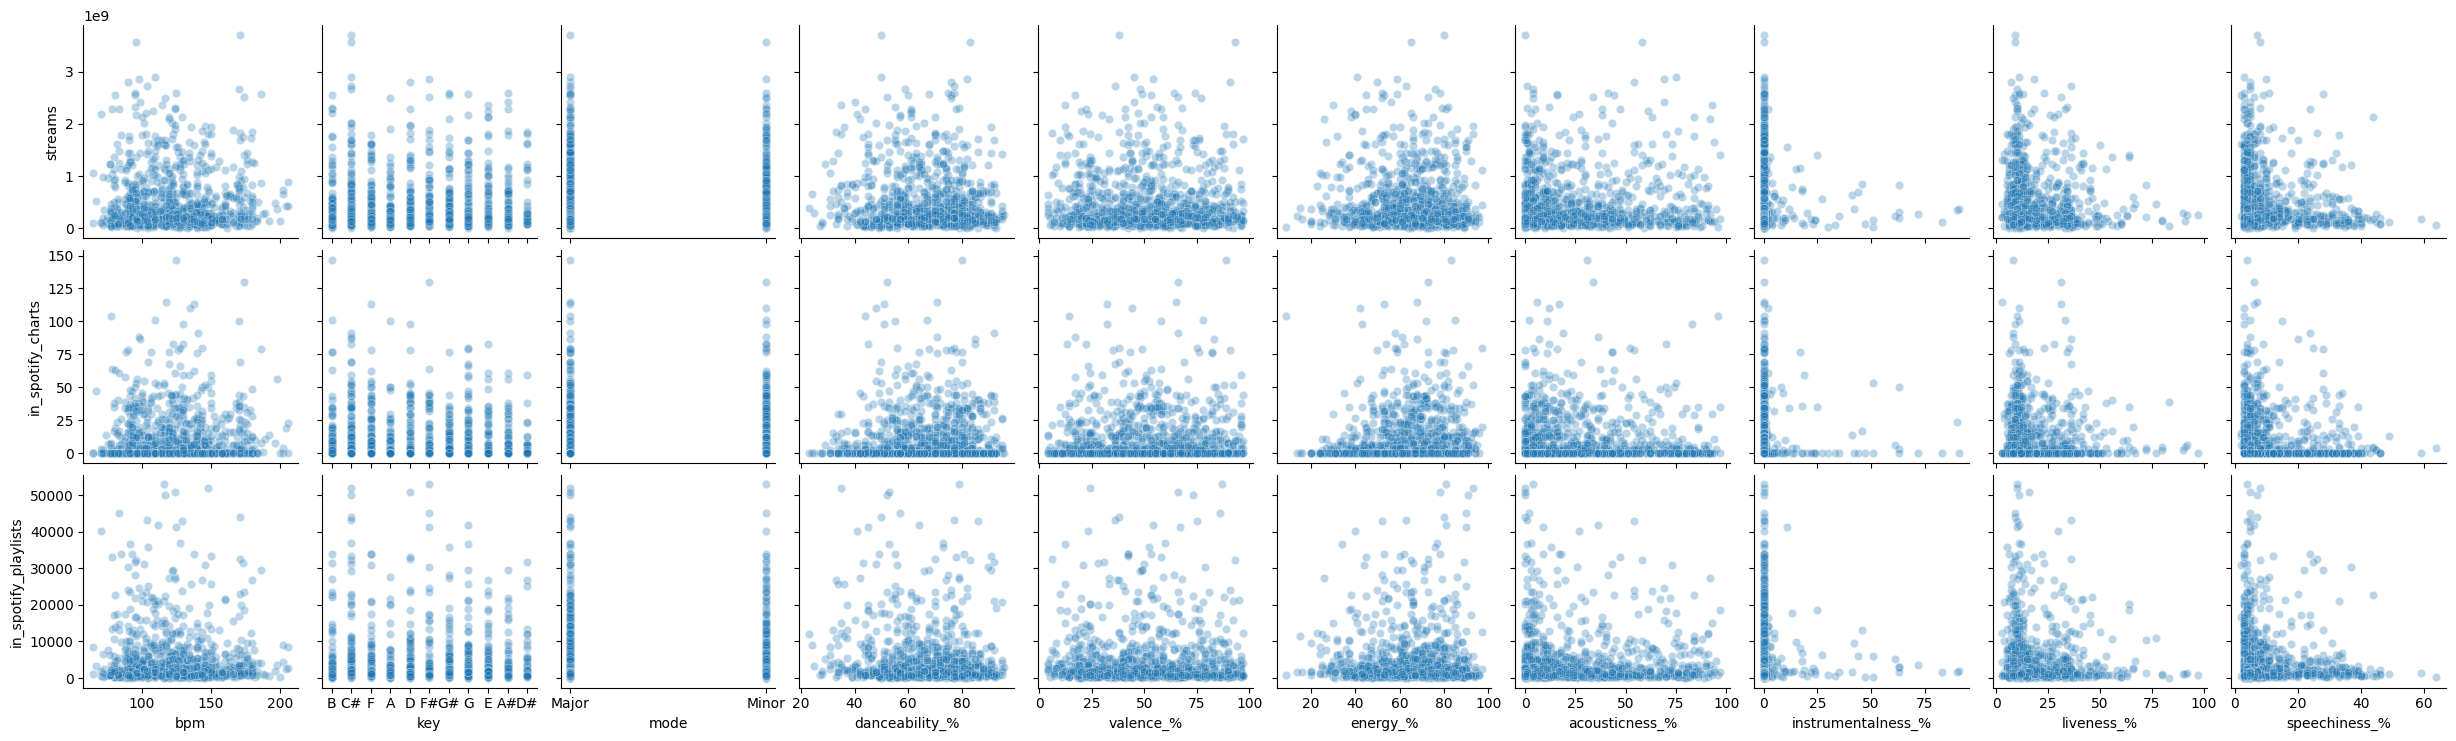

In [ ]:
# Forced conversion of stream counts to numeric as they weren't plotting or sorting properly otherwise.
df_data["streams"] = pd.to_numeric(df_data['streams'], errors='coerce')

sns.pairplot(
    df_data,
    x_vars=["bpm", "key", "mode", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"],
    y_vars=["streams", "in_spotify_charts", "in_spotify_playlists"],
    plot_kws={'alpha':0.3}
)

plt.show()

In [ ]:
# Which artist is the most popular in 2023? Are there any overpowering artists? How might this affect stream predictions?

In [ ]:
df_data.groupby(by="artist_name").streams.sum().sort_values(ascending=False)

# The Weeknd, Taylor Swift, Ed Sheeran, and Harry Styles all have reached over 10 billion streams in 2023. This might affect
# stream predictions insofar as songs by popular artists will inherently reach a greater audience than songs by less popular
# artists, regardless of the attributes of their songs' composition.

artist_name
The Weeknd                                                                               14185552870
Taylor Swift                                                                             14053658300
Ed Sheeran                                                                               13908947204
Harry Styles                                                                             11608645649
Bad Bunny                                                                                 9997799607
                                                                                            ...     
Offset, JID                                                                                 24975653
Mc Pedrinho, DJ 900                                                                         11956641
Sog, Ryan Castro, Peso Pluma                                                                11599388
Arijit Singh, Vishal Dadlani, Sukriti Kakar, Vishal-Shekhar, Shekhar Ravjiani, 

In [ ]:
# What is the percentage of artists that only appear in the dataset once? What might this suggest about the ability for new artists to break into the most popular song charts?

In [ ]:
df_data.artist_name.nunique() / df_data.artist_name.count() * 100
# About 67.6% of artists only appear in the dataset once. This suggests that it is fairly common for new artists to break into
# the most popular song charts. However, "unique artists" includes combinations of artists that appear elsewhere in the dataset,
# e.g. "Eminem, Dr. Dre"

67.64705882352942

In [ ]:
# What percentage of songs that are popular in 2023 weren't released in 2023?
# What is the oldest song to be popular this year?
# Might this suggest anything about the speed of trends in music?

((df_data.loc[df_data.released_year != 2023].count() / df_data.released_year.count()).released_year) * 100
# About 81.6% of the songs popular in 2023 weren't released in 2023.

81.61764705882352

In [ ]:
df_data.sort_values(by="released_year", ascending=True).head(10)
# The song lsited as the oldest from 1930 appears to be a data entry error. The actual oldest popular song is "White Christmas"
# by Bing Crosby, and every other song in the top 10 oldest songs is a Christmas song as well. This suggests that songs
# considered festive during specific times each year have more longevity than most other songs.

,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
439,Agudo Mï¿½ï¿½gi,"Styrx, utku INC, Thezth",3,1930,1,1,323,0,90598517,4,...,130,F#,Minor,65,49,80,22,4,7,5
469,White Christmas,"Bing Crosby, John Scott Trotter & His Orchestr...",3,1942,1,1,11940,0,395591396,73,...,96,A,Major,23,19,25,91,0,40,3
460,The Christmas Song (Merry Christmas To You) - ...,Nat King Cole,1,1946,11,1,11500,0,389771964,140,...,139,C#,Major,36,22,15,84,0,11,4
466,Let It Snow! Let It Snow! Let It Snow!,"Frank Sinatra, B. Swanson Quartet",2,1950,1,1,10585,0,473248298,126,...,143,D,Major,60,86,32,88,0,34,6
459,A Holly Jolly Christmas - Single Version,Burl Ives,1,1952,1,1,7930,0,395591396,108,...,140,NaN,Major,67,81,36,64,0,15,3
444,Jingle Bell Rock,Bobby Helms,1,1957,1,1,10326,0,741301563,165,...,119,D,Major,74,78,37,84,0,6,3
496,Jingle Bells - Remastered 1999,Frank Sinatra,1,1957,1,1,4326,0,178660459,32,...,175,G#,Major,51,94,34,73,0,10,5
476,It's Beginning to Look a Lot Like Christmas (w...,"Perry Como, The Fontane Sisters, Mitchell Ayre...",3,1958,1,1,6290,0,295998468,89,...,113,G,Major,73,72,32,77,0,15,5
495,Run Rudolph Run - Single Version,Chuck Berry,1,1958,1,1,8612,0,245350949,120,...,152,G,Minor,69,94,71,79,0,7,8
443,Rockin' Around The Christmas Tree,Brenda Lee,1,1958,1,1,14994,0,769213520,191,...,140,G#,Major,70,85,41,71,0,45,5


In [ ]:
# Using the charts of the different music platforms, which one seem to correlate the most with popularity?

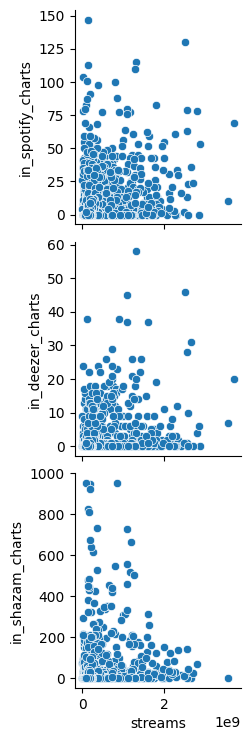

In [ ]:
df_data["in_shazam_charts"] = pd.to_numeric(df_data['in_shazam_charts'], errors='coerce')

sns.pairplot(
    df_data,
    x_vars=["streams"],
    y_vars=["in_spotify_charts", "in_deezer_charts", "in_shazam_charts"],
)

plt.show()

# If we are to define "popularity" as the number of streams on Spotify, the Shazam charts seem to correlate most with
# popularity as that scatterplot has the most obvious negative linear relationship. Since a "lower" number on charts is
# associated with a higher popularity (e.g. #1 on Spotify), it makes sense that the number of streams would have a negative
# correlation with the presense and rank of the song on charts. Perhaps Shazam has the most obvious relationship becase it often
# involves scanning songs heard around the user, and therefore, songs that are more popular are more likely to be scanned in
# the Shazam app.

In [ ]:
# Use forward/backward stepwise regression (taking out the features that don't make sense), graphing the error rates of each group of features.
# Find the number of features that best captures the variance without overfitting.


In [ ]:
X = df_data[["bpm", "key", "mode", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]]
y = df_data[["streams", "in_spotify_charts", "in_spotify_playlists"]]


In [ ]:
# I changed key and mode columns to numeric values because I decided they could be important features to consider in my regression
df_data = df_data.dropna(subset=['key'])
print("Unique values in 'key'", df_data['key'].unique()) # making sure it worked

df_data['key'] = df_data['key'].replace({'A': 0, 'A#': 1, 'B': 2, 'C#': 3, 'D': 4, 'D#': 5, 'E': 6, 'F': 7, 'F#': 8, 'G': 9, 'G#': 10})
df_data['mode'] = df_data['mode'].replace({'Major': 1, 'Minor': 0})
df_data = df_data.astype({'key': 'float64', 'mode': 'float64'})
df_data.sample(10)


Unique values in 'key' ['B' 'C#' 'F' 'A' 'D' 'F#' 'G#' 'G' 'E' 'A#' 'D#']


<ipython-input-23-bd18669bc175>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['key'] = df_data['key'].replace({'A': 0, 'A#': 1, 'B': 2, 'C#': 3, 'D': 4, 'D#': 5, 'E': 6, 'F': 7, 'F#': 8, 'G': 9, 'G#': 10})
<ipython-input-23-bd18669bc175>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['mode'] = df_data['mode'].replace({'Major': 1, 'Minor': 0})


,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
509,Gasoline,The Weeknd,1,2022,1,7,2297,0,116903579,11,...,123,8.0,0.0,74,35,73,0,0,21,5
507,Pepas,Farruko,1,2021,6,24,14114,17,1309887447,252,...,130,9.0,1.0,76,44,77,1,0,13,3
588,happier,Olivia Rodrigo,1,2021,5,21,3069,4,850608354,25,...,169,8.0,1.0,39,36,45,81,0,8,13
739,Cool for the Summer,Demi Lovato,1,2015,1,1,9243,0,677389855,155,...,114,7.0,0.0,59,30,62,1,0,8,4
149,El Gordo Trae El Mando,Chino Pacas,1,2023,1,27,539,21,255932395,7,...,140,9.0,0.0,74,96,80,18,0,5,5
94,Still With You,Jung Kook,1,2020,6,5,31,39,38411956,2,...,88,3.0,0.0,53,34,47,9,0,83,4
894,"Stay With Me (with Justin Timberlake, Halsey, ...","Calvin Harris, Halsey, Pharrell Williams, Just...",4,2022,7,15,3113,0,123473120,54,...,126,0.0,1.0,81,90,73,28,0,29,4
683,Hrs and Hrs,Muni Long,1,2021,11,19,1800,0,181328253,43,...,140,10.0,0.0,51,66,53,60,0,11,18
239,Efecto,Bad Bunny,1,2022,5,6,4004,33,1047480053,34,...,98,9.0,0.0,80,23,48,14,0,6,5
913,XQ Te Pones Asï¿,"Yandel, Feid",2,2022,9,13,308,0,47093942,6,...,92,1.0,1.0,81,48,70,13,0,15,7


In [ ]:
features = ["bpm", "key", "mode", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]
X = df_data[features]
Y  = df_data [["streams", "in_spotify_charts", "in_spotify_playlists"]]

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection

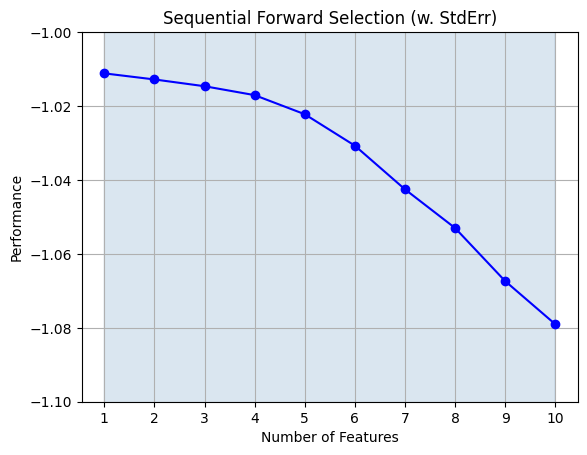

1 features:  ('speechiness_%',)
2 features:  ('bpm', 'speechiness_%')
3 features:  ('bpm', 'instrumentalness_%', 'speechiness_%')
4 features:  ('bpm', 'key', 'instrumentalness_%', 'speechiness_%')
5 features:  ('bpm', 'key', 'valence_%', 'instrumentalness_%', 'speechiness_%')
6 features:  ('bpm', 'key', 'mode', 'valence_%', 'instrumentalness_%', 'speechiness_%')
7 features:  ('bpm', 'key', 'mode', 'valence_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
8 features:  ('bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
9 features:  ('bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
10 features:  ('bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
Cross-validation scores:
1 features: -1.0111597662885532
2 features: -1.012805751337703
3 features: -1.0146382505325071
4 fe

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
lr = LinearRegression()
sfs_forward = SequentialFeatureSelector(lr,
          k_features=len(features),
          forward=True,
          floating=False,
          scoring='r2', #I used r2 for scoring instead of neg_mean_squared_error
          cv=5)

sfs_forward = sfs_forward.fit(X, Y)

fig_forward = plot_sequential_feature_selection(sfs_forward.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.ylim((-1.1, -1.0))

plt.show()

for k, items in sfs_forward.subsets_.items():
    print(f"{k} features: ", items["feature_names"])

print("Cross-validation scores:")
for k, items in sfs_forward.subsets_.items():
    print(f"{k} features: {items['avg_score']}")


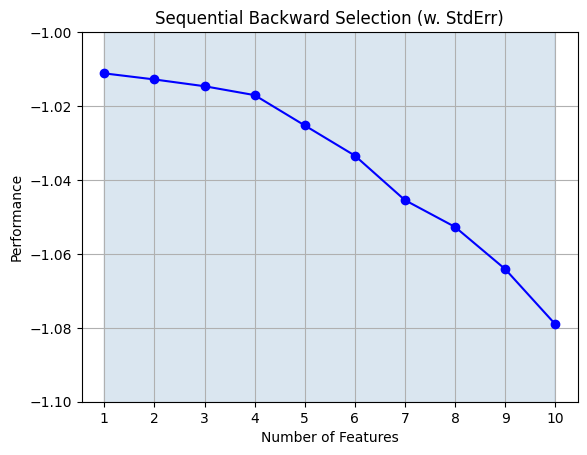

10 features:  ('bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
9 features:  ('bpm', 'key', 'mode', 'danceability_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%')
8 features:  ('bpm', 'key', 'mode', 'danceability_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'speechiness_%')
7 features:  ('bpm', 'key', 'mode', 'danceability_%', 'energy_%', 'instrumentalness_%', 'speechiness_%')
6 features:  ('bpm', 'key', 'mode', 'danceability_%', 'instrumentalness_%', 'speechiness_%')
5 features:  ('bpm', 'key', 'danceability_%', 'instrumentalness_%', 'speechiness_%')
4 features:  ('bpm', 'key', 'instrumentalness_%', 'speechiness_%')
3 features:  ('bpm', 'instrumentalness_%', 'speechiness_%')
2 features:  ('bpm', 'speechiness_%')
1 features:  ('speechiness_%',)
Cross-validation scores:
1 features: -1.0111597662885532
2 features: -1.012805751337703
3 features: -1.014638

In [ ]:
lr = LinearRegression()

sfs_backward = SequentialFeatureSelector(lr,
          k_features=1,
          forward=False,
          floating=False,
          scoring='r2',
          cv=5)

sfs_backward = sfs_backward.fit(X, Y)
fig_backward = plot_sequential_feature_selection(sfs_backward.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.ylim((-1.1, -1.0))
plt.grid()
plt.show()

for k, items in sfs_backward.subsets_.items():
    print(f"{k} features: ", items["feature_names"])

print("Cross-validation scores:")
for k, items in sfs_forward.subsets_.items():
    print(f"{k} features: {items['avg_score']}")

In [ ]:
# Looking at the graph, performance seems to differ relatively little from the 10 feature subset to the 7 feature subset, so the 7 feature subset may be best to use to avoid overfitting

In [ ]:
lr = LinearRegression()

#Fit the lr model on the selected features
selected_features = list(sfs_forward.k_feature_names_)
lr.fit(X[selected_features], Y)

coefficients = lr.coef_
if len(coefficients.shape) == 1:
    coefficients = coefficients.reshape(1, -1)
feature_importance = list(zip(selected_features, coefficients[0]))

feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

top_features = feature_importance[:3]

print("Top 3 features affecting popularity:")
for feature, coefficient in top_features:
    print(f"{feature}: {coefficient}")


Top 3 features affecting popularity:
mode: 35330168.4800349
speechiness_%: -5597455.964287423
instrumentalness_%: -4230508.054763126


In [ ]:
# What are the top 3 features that affect the popularity of a song? If it contains artist, does this suggest anything about music culture?

Mode, speechiness, and instrumentalness.

In [ ]:
# Create training data. Use a 70/30 train/test split.

In [ ]:
# X = df_data[["mode","instrumentalness_%", "speechiness_%"]]
# X = df_data[["bpm", "key", "mode", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]]
X = df_data[['bpm', 'key', 'mode', 'danceability_%', 'energy_%', 'instrumentalness_%', 'speechiness_%']]
y = df_data["streams"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [ ]:
# Using the features that you found above, create a prediction model using random forests, and using for loops and graphs, find which hyperparameter values leads to the best fit (not too under/overfit). These models should be predicting the nummber of streams.

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# n_est_values = [10, 50, 100, 200]
# max_depth_values = [None, 10, 20, 30]
# results = []

# for n in n_est_values:
#   for md in max_depth_values:
#     m = RandomForestRegressor(n_estimators=n, max_depth=md)
#     m.fit(X_train, y_train)
#     y_pred = m.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     results.append({'n_estimators': n, 'max_depth': md, 'mse': mse})

# results_df = pd.DataFrame(results)
# min_mse = results_df.loc[results_df.mse == results_df.mse.min()]
# min_mse

# # These hyperparameters lead to the best fit (though it changes every time this runs)

Text(0, 0.5, 'R2')

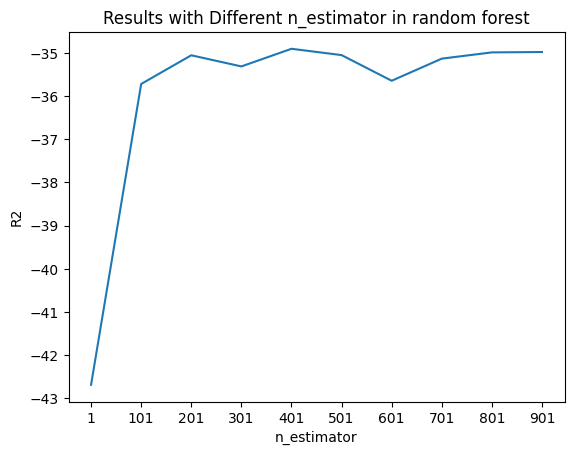

In [ ]:
# THIS CODE CELL TAKES A LONG TIME TO RUN

from sklearn.ensemble import RandomForestRegressor

# hyperparameter tuning
# investigating varying n_estimators

results_list = []
for n_estimator in range(1,1000,100):
    np.random.seed(100)
    depth = 3
    leaf_nodes = 3
    m = RandomForestRegressor(
        n_estimators= n_estimator,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes)
    accuracy_results = cross_val_score(m, X, y, cv=10, scoring = "r2")
    results_list.append([n_estimator, 100 * np.mean(accuracy_results)])
df_results_list_rf = pd.DataFrame(results_list, columns=["n_estimator", "r2"])

fig, ax = plt.subplots()
df_results_list_rf.set_index("n_estimator")["r2"].plot(ax = ax)
ax.set_title("Results with Different n_estimator in random forest")
ax.set_xticks(list(range(1,1000,100)))
ax.set_ylabel("R2")

Text(0, 0.5, 'R2')

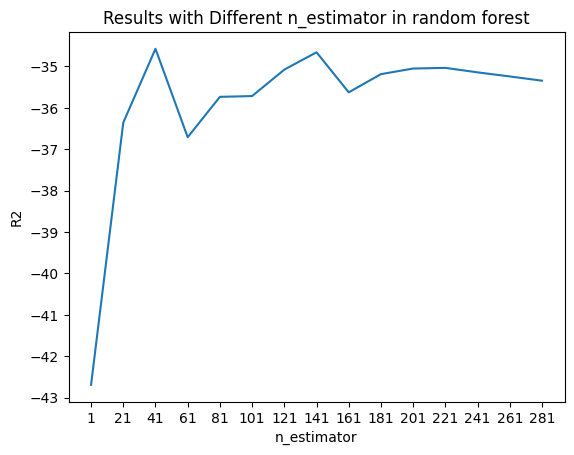

In [ ]:
results_list = []
for n_estimator in range(1,300,20):
    np.random.seed(100)
    depth = 3
    leaf_nodes = 3
    m = RandomForestRegressor(
        n_estimators= n_estimator,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes)
    accuracy_results = cross_val_score(m, X, y, cv=10, scoring = "r2")
    results_list.append([n_estimator, 100 * np.mean(accuracy_results)])
df_results_list_rf = pd.DataFrame(results_list, columns=["n_estimator", "r2"])

fig, ax = plt.subplots()
df_results_list_rf.set_index("n_estimator")["r2"].plot(ax = ax)
ax.set_title("Results with Different n_estimator in random forest")
ax.set_xticks(list(range(1,300,20)))
ax.set_ylabel("R2")

Text(0, 0.5, 'R2')

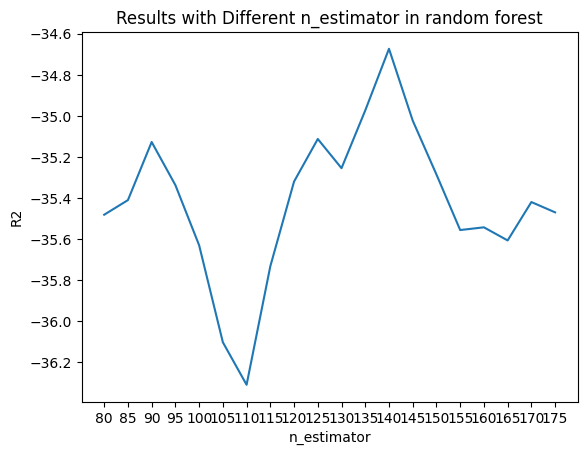

In [ ]:
results_list = []
for n_estimator in range(80,180,5):
    np.random.seed(100)
    depth = 3
    leaf_nodes = 3
    m = RandomForestRegressor(
        n_estimators= n_estimator,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes)
    accuracy_results = cross_val_score(m, X, y, cv=10, scoring = "r2")
    results_list.append([n_estimator, 100 * np.mean(accuracy_results)])
df_results_list_rf = pd.DataFrame(results_list, columns=["n_estimator", "r2"])

fig, ax = plt.subplots()
df_results_list_rf.set_index("n_estimator")["r2"].plot(ax = ax)
ax.set_title("Results with Different n_estimator in random forest")
ax.set_xticks(list(range(80,180,5)))
ax.set_ylabel("R2")

# n_estimator has peak around 140

Text(0, 0.5, 'R2')

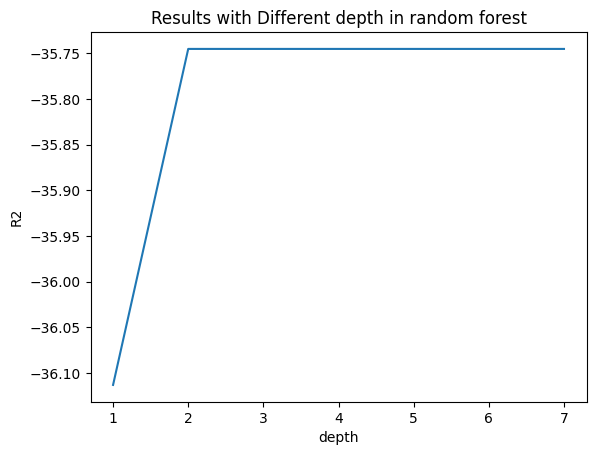

In [ ]:
# investigating varying depths

results_list = []
for depth in range(1,8,1):
    np.random.seed(100)
    n_estimator = 3
    leaf_nodes = 3
    m = RandomForestRegressor(
        n_estimators= n_estimator,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes)
    accuracy_results = cross_val_score(m, X, y, cv=10, scoring = "r2")
    results_list.append([depth, 100 * np.mean(accuracy_results)])
df_results_list_rf = pd.DataFrame(results_list, columns=["depth", "r2"])

fig, ax = plt.subplots()
df_results_list_rf.set_index("depth")["r2"].plot(ax = ax)
ax.set_title("Results with Different depth in random forest")
ax.set_xticks(list(range(1,8,1)))
ax.set_ylabel("R2")

# r2 score peaks after 2?

Text(0, 0.5, 'R2')

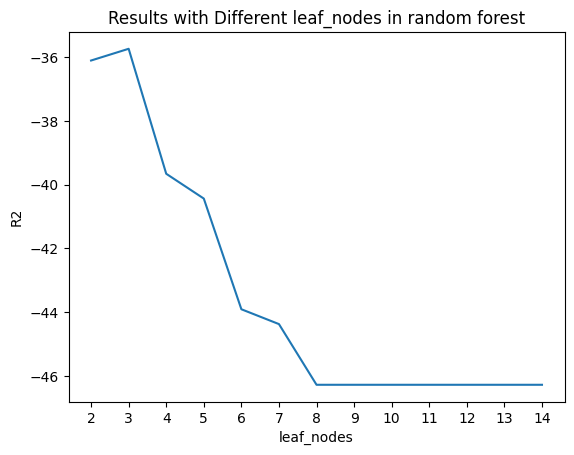

In [ ]:
# investigating varying leaf nodes

results_list = []
for leaf_nodes in range(2,15,1):
    np.random.seed(100)
    n_estimator = 3
    depth = 3
    m = RandomForestRegressor(
        n_estimators= n_estimator,
        max_depth = depth,
        max_leaf_nodes = leaf_nodes)
    accuracy_results = cross_val_score(m, X, y, cv=10, scoring = "r2", error_score='raise')
    results_list.append([leaf_nodes, 100 * np.mean(accuracy_results)])
df_results_list_rf = pd.DataFrame(results_list, columns=["leaf_nodes", "r2"])

fig, ax = plt.subplots()
df_results_list_rf.set_index("leaf_nodes")["r2"].plot(ax = ax)
ax.set_title("Results with Different leaf_nodes in random forest")
ax.set_xticks(list(range(2,15,1)))
ax.set_ylabel("R2")

# r2 score highest with 3 leaf nodes

In [ ]:
# testing to see if scaling is needed

np.random.seed(100)
rf = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=2, n_estimators = 140, max_leaf_nodes=3))
r2_results = cross_val_score(rf, X, y, cv=10, scoring = "neg_mean_squared_error")
print(np.mean(r2_results))

-3.329047836978083e+17


In [ ]:
np.random.seed(100)
rf = make_pipeline(RandomForestRegressor(max_depth=2, n_estimators = 140, max_leaf_nodes=3))
r2_results = cross_val_score(rf, X, y, cv=10, scoring = "neg_mean_squared_error")
print(np.mean(r2_results))

# scaling seems to have minimal effects on the r2 score

-3.329158187290485e+17


R2 score: -0.0010884868533371783
MSE 3.8124500880047194e+17


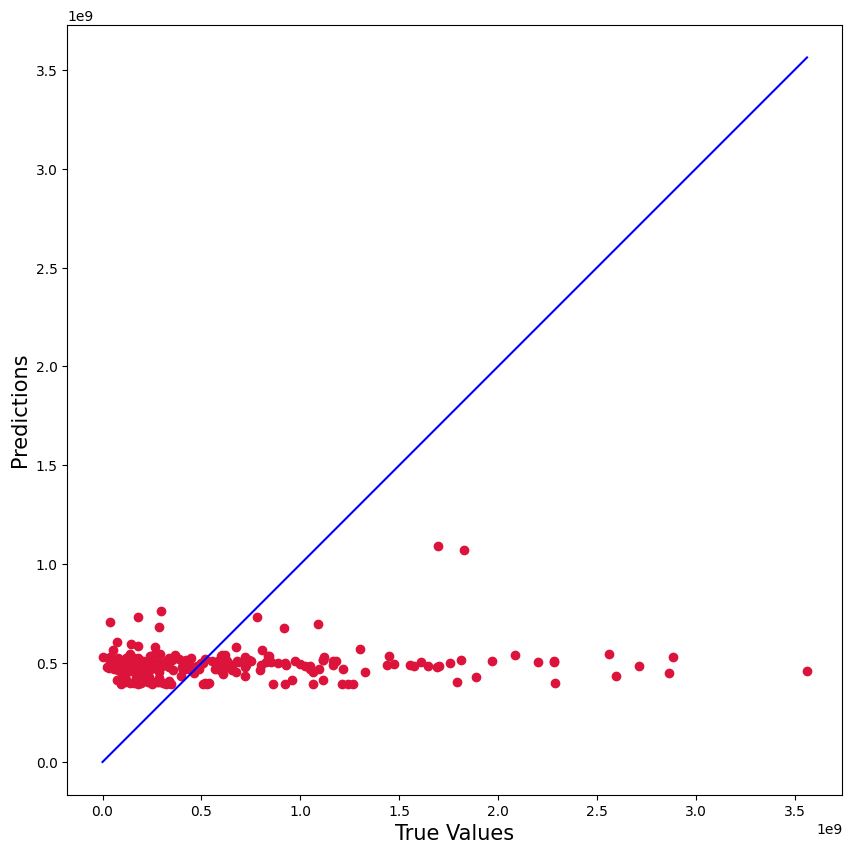

In [ ]:
# using those parameters to create random forest
np.random.seed(100)
m = RandomForestRegressor(
    n_estimators= 140,
    max_depth = 2,
    max_leaf_nodes = 3)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)
print("MSE", mse)

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
# _ = plt.scatter(y_test, y_pred, alpha = 0.5)
# _ = plt.xlabel("Actual Values")
# _ = plt.ylabel("Predicted Values")

In [ ]:
# Create a prediction model using linear regression, and using for loops and graphs, find which hyperparameter values leads to the best fit (not too under/overfit).

3.894526820834769e+17
-0.022640525667752875


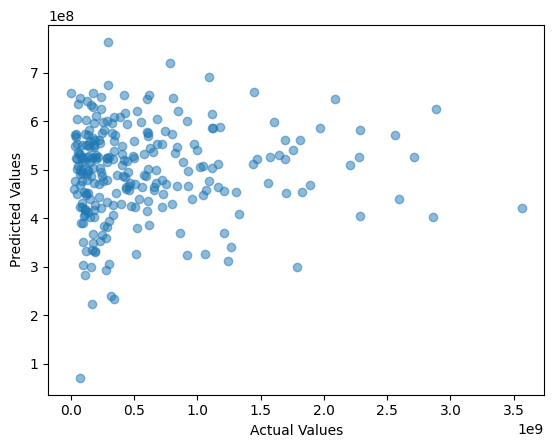

In [ ]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2_results = r2_score(y_test, y_pred)
print(mse)
print(r2_results)

_ = plt.scatter(y_test, y_pred, alpha = 0.5)
_ = plt.xlabel("Actual Values")
_ = plt.ylabel("Predicted Values")

In [ ]:
# Create a prediction model using Support Vector Machines, and using for loops and graphs, find which hyperparameter values leads to the best fit (not too under/overfit).

In [ ]:
from sklearn.svm import SVR

c_values = [0.1, 1, 10, 100, 1000]
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]
results = []

for c in c_values:
  for g in gamma_values:
    m = SVR(C = c, gamma = g)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'C ': c, 'Gamma ': g, 'mse': mse, 'r2': r2})

results_df = pd.DataFrame(results)
min_mse = results_df.loc[results_df.mse == results_df.mse.min()]
min_mse

,C,Gamma,mse,r2
23,1000.0,0.001,4.762157e+17,-0.250466


In [ ]:
# How do the performances of each model compare?

In [ ]:
# When comparing the R2 scores of the 3 models, the random forest regressor comes out on top with about -0.001. The linear regression comes in second with -0.02, and the SVR with -0.25.

In [ ]:
# Result/Popularity Feature (Dependent): Stream. Average chart ranking, Average number of playlist it’s added in.
# We could have a top 100 vs bottom 100 to compare more specifically on what features are important in making these songs popular.